In [1]:
!pip install spacy --user
!python3 -m spacy download it_core_news_sm
!pip3 install -U spacy
!pip3 install spacy
!python -m spacy download it_core_news_sm

     |████████████████████████████████| 21.1 MB 60.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
     |████████████████████████████████| 21.1 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import pandas as pd

In [3]:
df= pd.read_csv('Books.csv')
df

,Unnamed: 0,_id,author,contents,publishing house,year
0,0,Jane Eyre_Feltrinelli_pulito.txt,Charlotte Brontë,Quel giorno era impossibile uscire a passeggio...,Feltrinelli Editore,2014
1,1,Jane Eyre_Treves_pulito.txt,Charlotte Brontë,In quel giorno era impossibile passeggiare. La...,Fratelli Treves Editori,1904


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
df['Frasi']= df.apply(lambda row: nltk.sent_tokenize(row['contents']), axis=1)
df

,Unnamed: 0,_id,author,contents,publishing house,year,Frasi
0,0,Jane Eyre_Feltrinelli_pulito.txt,Charlotte Brontë,Quel giorno era impossibile uscire a passeggio...,Feltrinelli Editore,2014,[Quel giorno era impossibile uscire a passeggi...
1,1,Jane Eyre_Treves_pulito.txt,Charlotte Brontë,In quel giorno era impossibile passeggiare. La...,Fratelli Treves Editori,1904,"[In quel giorno era impossibile passeggiare., ..."


In [6]:
import spacy
from spacy.lang.it.examples import sentences 
from tqdm.notebook import tqdm
tqdm.pandas()
nlp = spacy.load('it_core_news_sm')
nlp.max_length = 1064150 
pipe = nlp.pipe(df['contents'], n_process=2, batch_size=2000)

In [7]:
docs = [x for x in tqdm(pipe)]

0it [00:00, ?it/s]

In [8]:
df['spacy_doc'] = docs

In [9]:
df['POS_spacy'] = df['spacy_doc'].progress_apply(lambda x: [(y.text, y.pos_) for y in x])

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
df['lemmatized'] = df['spacy_doc'].progress_apply(lambda x: " ".join([y.lemma_ for y in x if len(x)>1]))

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
def clean(x):
  stop = stopwords.words("italian")
  stop = stop + list(string.punctuation)
  words  = [w for w in word_tokenize(x.lower()) if w.isalpha() and w not in stop]
  return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df['Frasi2']= df.apply(lambda row: nltk.sent_tokenize(row['lemmatized']), axis=1)
df

,Unnamed: 0,_id,author,contents,publishing house,year,Frasi,spacy_doc,POS_spacy,lemmatized,Frasi2
0,0,Jane Eyre_Feltrinelli_pulito.txt,Charlotte Brontë,Quel giorno era impossibile uscire a passeggio...,Feltrinelli Editore,2014,[Quel giorno era impossibile uscire a passeggi...,"(Quel, giorno, era, impossibile, uscire, a, pa...","[(Quel, DET), (giorno, NOUN), (era, AUX), (imp...",quello giorno essere impossibile uscire a pass...,[quello giorno essere impossibile uscire a pas...
1,1,Jane Eyre_Treves_pulito.txt,Charlotte Brontë,In quel giorno era impossibile passeggiare. La...,Fratelli Treves Editori,1904,"[In quel giorno era impossibile passeggiare., ...","(In, quel, giorno, era, impossibile, passeggia...","[(In, ADP), (quel, DET), (giorno, NOUN), (era,...",in quello giorno essere impossibile passeggiar...,[in quello giorno essere impossibile passeggia...


In [13]:
import numpy as np
documents = (np.array(df['Frasi2'][0]))
documents2 = (np.array(df['Frasi2'][1]))

data1 = pd.DataFrame(df['Frasi2'][0],columns={'text'})
data2 = pd.DataFrame(df['Frasi2'][1], columns={'text'})
data = data2.append(data1, ignore_index=True)

In [14]:
data["Lemmi"] = data["text"].apply(clean)

In [15]:
text = data["Lemmi"]

In [16]:
text

0                    giorno essere impossibile passeggiare
1        mattina avere errare ora boschetto spogliare f...
2                                          essere contento
3        essere mai piacere lunghe passeggiate sopra fr...
4        eliza john georgiana essere aggruppare salotto...
                               ...                        
19797    paura morte offuscare ultimo ora st john mente...
19798    stesso parola essere pegno signore dire avere ...
19799    ogni giorno annunciare sempre grande chiarezza...
19800    ora ora rispondere fervore crescente amen veni...
19801                                                     
Name: Lemmi, Length: 19802, dtype: object

In [17]:
data.isna().sum() 

text     0
Lemmi    0
dtype: int64

In [18]:
# Generating bag of words features.
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow = count_vect.fit_transform(text.values)
bow.shape

(19802, 14291)

In [19]:
bow

<19802x14291 sparse matrix of type '<class 'numpy.int64'>'
	with 183867 stored elements in Compressed Sparse Row format>

In [20]:
# to understand what kind of words generated as columns by BOW
terms = count_vect.get_feature_names()

In [21]:
#first 10 columns generated by BOW
terms[1:10]

['abbagliante',
 'abbagliare',
 'abbagliate',
 'abbaglio',
 'abbaiare',
 'abbaino',
 'abballinate',
 'abbandonala',
 'abbandonandomi']

In [22]:
#using all processes jobs=-1 and k means++ for starting initilization advantage
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 10,init='k-means++', n_jobs = -1,random_state=99)
model.fit(bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

In [23]:
labels = model.labels_
cluster_center=model.cluster_centers_

In [24]:
cluster_center

array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.000129, 0.      , ..., 0.      , 0.000129, 0.000129],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [25]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(bow, labels, metric='euclidean')

In [26]:
# which tells us that clusters are far away from each other 
silhouette_score

0.011904054279262818

In [27]:
# Giving Labels/assigning a cluster to each sentence 

data['Bow Clus Label'] = model.labels_ 
data.head(2)

,text,Lemmi,Bow Clus Label
0,in quello giorno essere impossibile passeggiare .,giorno essere impossibile passeggiare,5
1,il mattina avere errare per uno ora nel bosche...,mattina avere errare ora boschetto spogliare f...,0


In [28]:
# How many sentences belong to each cluster
data.groupby(['Bow Clus Label'])['Lemmi'].count()

Bow Clus Label
0    1503
1    7752
2    2238
3     494
4     602
5    4890
6     785
7     252
8     618
9     668
Name: Lemmi, dtype: int64

In [29]:
#Find the top 10 features of cluster centriod
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: avere
 essere
 molto
 fare
 stare
 me
 quando
 così
 signore
 mai
Cluster 1: fare
 dire
 molto
 signore
 me
 potere
 stare
 jane
 sì
 dovere
Cluster 2: avere
 fare
 dire
 molto
 potere
 me
 signore
 mai
 rochester
 parlare
Cluster 3: essere
 avere
 molto
 stare
 potere
 me
 dire
 fare
 così
 signore
Cluster 4: essere
 dire
 avere
 molto
 signore
 stare
 fare
 volere
 me
 quando
Cluster 5: essere
 molto
 stare
 fare
 me
 signore
 così
 quando
 dovere
 rochester
Cluster 6: andare
 vedere
 sapere
 fare
 molto
 potere
 dire
 dovere
 signore
 quando
Cluster 7: avere
 essere
 fare
 potere
 dire
 molto
 mai
 quando
 me
 vedere
Cluster 8: essere
 potere
 avere
 fare
 molto
 così
 me
 dire
 vedere
 stare
Cluster 9: volere
 essere
 avere
 fare
 dire
 cosa
 molto
 me
 bene
 solo


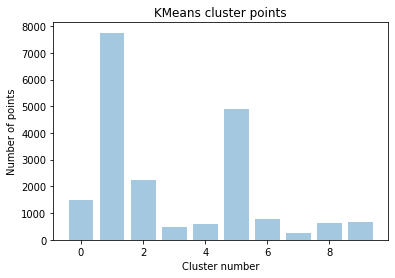

In [30]:
# visually how sentences are distributed across 10 clusters 
import matplotlib.pyplot as plt
plt.bar([x for x in range(10)], data.groupby(['Bow Clus Label'])['Lemmi'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [31]:
# Reading a sentence which belong to each group.
for i in range(10):
    print("A sentence of assigned to cluster ", i)
    print("-" * 70)
    print(data.iloc[data.groupby(['Bow Clus Label']).groups[i][0]]['Lemmi'])
    print('\n')
    print("_" * 70)

A sentence of assigned to cluster  0
----------------------------------------------------------------------
mattina avere errare ora boschetto spogliare foglia dopo pranzo quando essere invitare signora reed desinare presto vento gelato inverno avere portare seco nubi così scure pioggia così penetrare potere pensare nessun escursione


______________________________________________________________________
A sentence of assigned to cluster  1
----------------------------------------------------------------------
domandai


______________________________________________________________________
A sentence of assigned to cluster  2
----------------------------------------------------------------------
ella avere proibire unirmi gruppo dire deplorare necessità trovavasi tenere così lontano fino momento bessie guarentirebbe studiare acquistare carattere molto socievole molto infantile maniera molto cortese qualcosa molto radioso molto aperto molto sincero potere concedere stesso privilegio b

In [32]:
#considers sample of 3 random sentences for cluster 0

print(data.iloc[data.groupby(['Bow Clus Label']).groups[0][3]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[0][6]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[0][9]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[0][12]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[0][15]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[0][18]]['Lemmi'])

john essere ragazzo quattordici anno avere allora dieci solamente
______________________________________________________________________
servire avere volere prendere difesa offendere giovine padrone signora reed argomento essere cieco sordo ella fingere accorgersi quando picchiare insultare benché egli ciò fare spesso presenza molto spesso quando essere
______________________________________________________________________
avere appunto leggere storia roma goldsmith essere fare concetto nerone caligola credere dovere esporre mai voce alto
______________________________________________________________________
essi avere molto danaro avere punto dovere cercare studiare essere umile rendere gradire
______________________________________________________________________
sedile bessie aspro signorina abbot avere lasciare essere ottomana basso collocare vicino caminetto marmo
______________________________________________________________________
consuetudine avere prendere essere umile dubit

In [33]:
#consider sample of 3 random sentences for cluster 1

print(data.iloc[data.groupby(['Bow Clus Label']).groups[1][3]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[1][15]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[1][25]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[1][20]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[1][35]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[1][40]]['Lemmi'])

tanto tanto sfogliare libro gettare occhiata difuori studiare aspetto serata inverno lontananza scorgere pallido striscia nebbia nuvola molto vicino albero bagnato pianta sradicare temporale infine pioggia incessante lungo lamentevoli ventata respingere sibilare
______________________________________________________________________
collocare poltrona fare cenno accostarmi stare ritto dinanzi
______________________________________________________________________

______________________________________________________________________
cosa fare dietro tenda
______________________________________________________________________
allora signora reed soggiungere portatela camera rosso chiudetevela dentro
______________________________________________________________________
scandalosa condotta signorina eyre


In [34]:
#consider sample of 3 random sentences for cluster 2

print(data.iloc[data.groupby(['Bow Clus Label']).groups[2][3]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[2][15]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[2][25]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[2][30]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[2][35]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[2][40]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[2][45]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[2][50]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[2][55]]['Lemmi'])

tempo avere dovere trovare collegio madre avevalo togliere mese due pretesto delicato salute
______________________________________________________________________
dopo poco accorrere qualcuno avvicinare me sollevare collocandomi posizione molto comodo nessuno avere mai trattare fino momento tanto sollecitudine affettuoso
______________________________________________________________________
avere desiderare rispondere sinceramente domanda
______________________________________________________________________
nonno reed irritare disubbidienza avere diseredare mamma
______________________________________________________________________
appena bessie avere vestire padroncine solere scendere rumoroso regione cucina dispensa portare seco lume
______________________________________________________________________
respiro caldo avere avere dire sbarazzare cristallo strato ghiaccio così potere vedere fuori
______________________________________________________________________
egli volgere len

In [35]:
#consider sample of 3 random sentences for cluster 3

print(data.iloc[data.groupby(['Bow Clus Label']).groups[3][3]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[3][15]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[3][25]]['Lemmi'])

dire essere bene aggiungere bessie voce essere aspro dovere cercare rendere utile fare piacevole allora forse potere rimaner qui divenire violento brutale signora mandare via essere certo
______________________________________________________________________
essere molto avere sotterrare bimba cinque anno essere buono anima essere volare cielo potere dire stesso essere chiamare altro mondo
______________________________________________________________________
principio lezione ella essere primo filo qualche errore pronunzia essere fermare quando dovere essere mandare fondo stanza signorina scatcherd continuare perseguitarla laggiù incessante osservazione


In [36]:
#consider sample of 3 random sentences for cluster 4

print(data.iloc[data.groupby(['Bow Clus Label']).groups[4][3]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[4][15]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[4][25]]['Lemmi'])

essere mettere gridare senza ragione dire abbot irritata
______________________________________________________________________
essere finto essere stare avere dire volere bene volere bene dichiaro odiare molto ogni altro eccettuare john reed
______________________________________________________________________
bimba essere molto piccino essere mandare qui solo dire posare candeliere tavola


In [37]:
#consider sample of 3 random sentences for cluster 5

print(data.iloc[data.groupby(['Bow Clus Label']).groups[5][3]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[5][15]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[5][25]]['Lemmi'])

eliza john georgiana essere aggruppare salotto attorno mamma sdraiare sofà accanto fuoco circondare bambino momento questionare fra né piangere parere perfettamente felice
______________________________________________________________________
essere momento divenivo selvaggio terrore ispirare sapere ricorrere minaccia punizione
______________________________________________________________________
essere padrone


In [38]:
#consider sample of 3 random sentences for cluster 6

print(data.iloc[data.groupby(['Bow Clus Label']).groups[6][2]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[6][21]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[6][23]]['Lemmi'])

egli stare tre minuto mostrarmi lingua allungare molto potere sapere stare picchiare spiare brutto fare momento collera avrebbegli fare allungare mano
______________________________________________________________________
bessie vantare bello paesaggio fiore grazioso dipinto poi sapere cantare romanza recitare tradurre libro francese
______________________________________________________________________
venite andare giù


In [39]:
#consider sample of 3 random sentences for cluster 7

print(data.iloc[data.groupby(['Bow Clus Label']).groups[7][5]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[7][10]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[7][18]]['Lemmi'])

dubitare avere mai dubitato signore reed essere vivere avere trattare bontà ora mentre guardare letto bianco parete scure occhio essere attrarre tanto tanto verso specchio mandare altro cupo riflesso tornare mente ciò avere udire dire morto turbare riposo tomba violazione ultimo volontà ritornare terra punire spergiuro vendicare oppresso
______________________________________________________________________
credere signore bockelhurst avere accennare lettera tre settimana fa bimba avere carattere nè tendenza avere desiderare trovare
______________________________________________________________________
cosa aggiungere signore bockelhurst avere sapere benefattrice pio caritatevole signora avere adottare quando rimanere orfano avere educare insieme figlia disgraziata bambina avere pagare bontà generosità ingratitudine così grande eccellente signora reed essere stare costringere separare jane figlio affinchè esempio contaminare purezza


In [40]:
#consider sample of 3 random sentences for cluster 8

print(data.iloc[data.groupby(['Bow Clus Label']).groups[8][5]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[8][10]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[8][20]]['Lemmi'])

avere dovere credermi paradiso assuefare essere continuo rimprovero sforzo incompreso nervo essere così scosso calma potere molto calmare piacere potere molto eccitarli piacevolmente
______________________________________________________________________
cosa essere inferno potere dirmelo essere abisso fiamma
______________________________________________________________________
passare tempo esaminare pensare riflessione essere troppo vago troppo spesso interrompere potere essere riferire


In [41]:
#consider sample of 3 random sentences for cluster 9

print(data.iloc[data.groupby(['Bow Clus Label']).groups[9][5]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[9][10]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Bow Clus Label']).groups[9][20]]['Lemmi'])

però volere bene essere equo dire neppur volere
______________________________________________________________________
no risposi volere appartenere povero gente
______________________________________________________________________
madre quando venire qui settimana passato dire volere vedere figlio posto


KMEANS USING TF IDF

In [42]:
#tfidf vector initililization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(text.values)
tfidf.shape

(19802, 14291)

In [43]:
from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters = 10, n_jobs = -1,random_state=99)
model_tf.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

In [44]:
labels_tf = model_tf.labels_
cluster_center_tf=model_tf.cluster_centers_

In [45]:
cluster_center_tf

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.73066404e-05, 0.00000000e+00, ...,
        3.93614170e-05, 4.83058592e-05, 6.22509314e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [46]:
# to understand what kind of words generated as columns by BOW
terms1 = tfidf_vect.get_feature_names()

In [47]:
terms1[1:10]

['abbagliante',
 'abbagliare',
 'abbagliate',
 'abbaglio',
 'abbaiare',
 'abbaino',
 'abballinate',
 'abbandonala',
 'abbandonandomi']

In [48]:
from sklearn import metrics
silhouette_score_tf = metrics.silhouette_score(tfidf, labels_tf, metric='euclidean')

In [49]:
silhouette_score_tf

0.011567070909185889

In [50]:
# Giving Labels/assigning a cluster to each sentence
df1 = data
df1['Tfidf Clus Label'] = model_tf.labels_
df1.head(5)

,text,Lemmi,Bow Clus Label,Tfidf Clus Label
0,in quello giorno essere impossibile passeggiare .,giorno essere impossibile passeggiare,5,5
1,il mattina avere errare per uno ora nel bosche...,mattina avere errare ora boschetto spogliare f...,0,9
2,ne essere contento .,essere contento,5,5
3,non mi essere mai piacere il lunghe passeggiat...,essere mai piacere lunghe passeggiate sopra fr...,5,5
4,"eliza , John e georgiana essere aggruppare in ...",eliza john georgiana essere aggruppare salotto...,5,0


In [51]:
# How many sentences belong to each cluster

df1.groupby(['Tfidf Clus Label'])['Lemmi'].count()

Tfidf Clus Label
0     450
1    8693
2     164
3     996
4     239
5    4183
6    1357
7    2743
8     262
9     715
Name: Lemmi, dtype: int64

In [52]:
#Find the top 10 features of cluster centriod
print("Top terms per cluster:")
order_centroids = model_tf.cluster_centers_.argsort()[:, ::-1]
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 0: fra
 lungo
 essere
 avere
 molto
 poco
 me
 giorno
 fare
 due
Cluster 1: jane
 dire
 molto
 me
 essere
 andare
 volere
 oh
 potere
 vedere
Cluster 2: domandare
 essere
 cosa
 voce
 volere
 avere
 bessie
 rochester
 signore
 stare
Cluster 3: signore
 rochester
 mr
 essere
 avere
 dire
 andare
 me
 molto
 potere
Cluster 4: no
 signore
 oh
 essere
 certo
 avere
 sapere
 dire
 jane
 mai
Cluster 5: essere
 stare
 molto
 dire
 potere
 me
 quando
 cosa
 sapere
 vero
Cluster 6: fare
 cosa
 avere
 essere
 potere
 volere
 dovere
 dire
 sapere
 me
Cluster 7: avere
 dire
 essere
 molto
 potere
 mai
 me
 sentire
 volere
 cosa
Cluster 8: sì
 signore
 essere
 dire
 avere
 jane
 rispondere
 volere
 vero
 me
Cluster 9: così
 essere
 avere
 potere
 fare
 dire
 molto
 stare
 proprio
 me


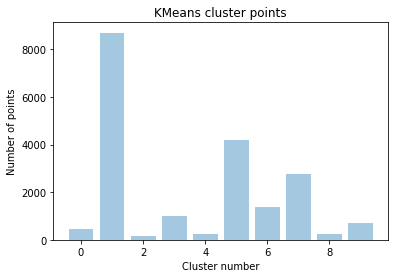

In [53]:
# visually how sentences are distributed across 10 clusters 

plt.bar([x for x in range(10)], df1.groupby(['Tfidf Clus Label'])['Lemmi'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [54]:
#consider sample of 3 random sentences for cluster 0

print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[0][3]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[0][15]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[0][25]]['Lemmi'])

ora v insegnare frugare biblioteca libro essere appartenere casa appartenere fra poco anno
______________________________________________________________________
zia parlare mai mandare pensione sentire istintivamente ella avere tollerare lungo sotto tetto sguardo ogni tanto fissare me rivelare avversione insormontabile
______________________________________________________________________
sera bessie narrare molto bello fra novella cantare molto dolce canzone


In [55]:
#consider sample of 3 random sentences for cluster 1

print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[1][3]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[1][15]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[1][25]]['Lemmi'])

collocare allora vano finestra sedendomi piede turco tirare tenda damasco rosso trovare rinchiusa doppio ritiro
______________________________________________________________________
temere soltanto interruzione tardare
______________________________________________________________________
john volere molto bene né madre né sorella


In [56]:
#consider sample of 3 random sentences for cluster 2

print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[2][3]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[2][15]]['Lemmi'])
print("_" * 70)
print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[2][25]]['Lemmi'])

avere bisogno dormire signorina domandare bessie certo dolcezza voce
______________________________________________________________________
essere davvero jane domandare voce dolce
______________________________________________________________________
essere straniero domandare meravigliata


In [57]:
# Reading a sentence which belong to each group.
for i in range(10):
    print("2 sentences of assigned to cluster ", i)
    print("-" * 70) 
    print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[i][0]]['Lemmi'])
    print('\n')
    print(data.iloc[data.groupby(['Tfidf Clus Label']).groups[i][1]]['Lemmi'])
    print('\n')
    print("_" * 70)

2 sentences of assigned to cluster  0
----------------------------------------------------------------------
eliza john georgiana essere aggruppare salotto attorno mamma sdraiare sofà accanto fuoco circondare bambino momento questionare fra né piangere parere perfettamente felice


tanto tanto sfogliare libro gettare occhiata difuori studiare aspetto serata inverno lontananza scorgere pallido striscia nebbia nuvola molto vicino albero bagnato pianta sradicare temporale infine pioggia incessante lungo lamentevoli ventata respingere sibilare


______________________________________________________________________
2 sentences of assigned to cluster  1
----------------------------------------------------------------------
domandai


sedetevi qualche posto stare buono fino quando sapere parlare ragionevolmente


______________________________________________________________________
2 sentences of assigned to cluster  2
----------------------------------------------------------------------
d

Average Word to Vector

In [58]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [59]:
# Train your own Word2Vec model
i=0
list_of_sent=[]
for sent in data['Lemmi'].values:
    list_of_sent.append(sent.split())

In [60]:
import gensim
# Training the wor2vec model
w2v_model=gensim.models.Word2Vec(list_of_sent,size=100, workers=4)

In [61]:
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence is stored in this train
for sent in list_of_sent: # for each sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


(19802, 100)

In [62]:
print(data['Lemmi'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

giorno essere impossibile passeggiare
*****************************************************************
['giorno', 'essere', 'impossibile', 'passeggiare']


In [63]:
# Number of clusters to check.
num_clus = [x for x in range(0,10)]

In [64]:
# Number of clusters to check.
num_clus = [x for x in range(0,10)]
num_clus

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [65]:
# Training
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters = 10)
model2.fit(sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [66]:
word_cluster_pred=model2.predict(sent_vectors)
word_cluster_pred_2=model2.labels_
word_cluster_center=model2.cluster_centers_

In [67]:
word_cluster_center[1:2]

array([[-0.02499043,  0.00615986,  0.01423412, -0.01855015, -0.02050142,
         0.0020105 ,  0.00372707,  0.01204326, -0.00336448, -0.02250255,
         0.00560946, -0.0001288 , -0.00031873,  0.00273796, -0.0060132 ,
         0.01832783, -0.02290911,  0.00148468,  0.04397122,  0.01660821,
        -0.02723861, -0.00806927,  0.01484618, -0.01009509, -0.01697414,
        -0.01013092, -0.00526315, -0.00396241,  0.01755219,  0.01415041,
         0.0032258 , -0.00174081,  0.02063406, -0.01651253, -0.00357627,
        -0.00891917,  0.00699409, -0.00177397, -0.01147437,  0.01769273,
         0.01301807,  0.00029761, -0.01249411,  0.00345242,  0.00745388,
         0.00063392,  0.01217474, -0.01601513,  0.00904763, -0.01024653,
         0.00608171, -0.0138072 , -0.00582597, -0.00163969, -0.0034959 ,
         0.00147737, -0.01222536,  0.00329088, -0.0235375 , -0.03148214,
         0.00374026,  0.00024907,  0.02022368,  0.00647752, -0.0013437 ,
         0.02008196,  0.01098451,  0.01852507, -0.0

In [68]:
# Giving Labels/assigning a cluster to each point/text 
dfa = df1
dfa['AVG-W2V Clus Label'] = model2.labels_
dfa.head(2)

,text,Lemmi,Bow Clus Label,Tfidf Clus Label,AVG-W2V Clus Label
0,in quello giorno essere impossibile passeggiare .,giorno essere impossibile passeggiare,5,5,0
1,il mattina avere errare per uno ora nel bosche...,mattina avere errare ora boschetto spogliare f...,0,9,7


In [69]:
# How many points belong to each cluster
dfa.groupby(['AVG-W2V Clus Label'])['Lemmi'].count()

AVG-W2V Clus Label
0    4725
1     419
2    2560
3     151
4    2101
5    2204
6     745
7    4644
8    1712
9     541
Name: Lemmi, dtype: int64

In [70]:
# Reading a sentence which belong to each group.
for i in range(10):
    print("A sentence of assigned to cluster ", i)
    print("-" * 70)
    print(dfa.iloc[dfa.groupby(['AVG-W2V Clus Label']).groups[i][0]]['Lemmi'])
    print('\n')
    print(dfa.iloc[dfa.groupby(['AVG-W2V Clus Label']).groups[i][1]]['Lemmi'])
    print('\n')
    print("_" * 70)

A sentence of assigned to cluster  0
----------------------------------------------------------------------
giorno essere impossibile passeggiare


essere contento


______________________________________________________________________
A sentence of assigned to cluster  1
----------------------------------------------------------------------
leggevo





______________________________________________________________________
A sentence of assigned to cluster  2
----------------------------------------------------------------------
domandai


larghe piega cortina scarlatta nascondere ciò essere destra sinistra invetriata proteggere separare triste giornata novembre


______________________________________________________________________
A sentence of assigned to cluster  3
----------------------------------------------------------------------
addio signore


sì signore


______________________________________________________________________
A sentence of assigned to cluster  4
---------

Clustering DBSCAN

In [71]:
from sklearn.cluster import DBSCAN
# Computing 200th Nearest neighbour distance
minPts = 2 * 100

def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 200 and dists[199] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199] # Dist 199 contains the distance of 200th nearest neighbour.

In [72]:
# Computing the 200th nearest neighbour distance of some point the dataset:
twohundrethneigh = []
for val in sent_vectors[:1500]:
    twohundrethneigh.append( compute200thnearestneighbour(val, sent_vectors[:1500]) )
twohundrethneigh.sort()

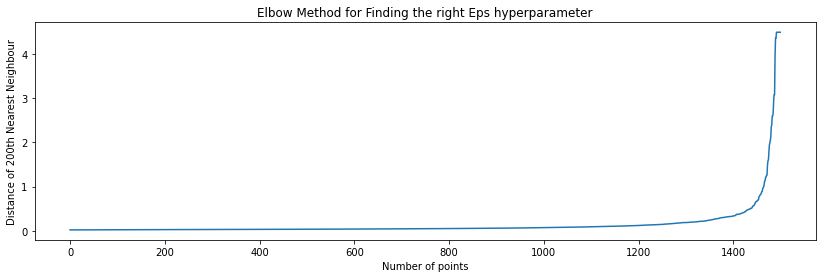

In [73]:
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [74]:
# Training DBSCAN :
model = DBSCAN(eps = 1, min_samples = minPts, n_jobs=-1)
model.fit(sent_vectors)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=200, n_jobs=-1, p=None)

In [75]:
dfdb = dfa
dfdb['AVG-W2V Clus Label'] = model.labels_
dfdb.head(2)

,text,Lemmi,Bow Clus Label,Tfidf Clus Label,AVG-W2V Clus Label
0,in quello giorno essere impossibile passeggiare .,giorno essere impossibile passeggiare,5,5,0
1,il mattina avere errare per uno ora nel bosche...,mattina avere errare ora boschetto spogliare f...,0,9,0


In [76]:
dfdb.groupby(['AVG-W2V Clus Label'][0]).count()

,text,Lemmi,Bow Clus Label,Tfidf Clus Label
AVG-W2V Clus Label,,,,
-1,20,20,20,20
0,19782,19782,19782,19782


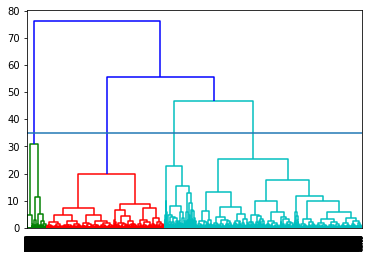

In [77]:
import scipy
from scipy.cluster import hierarchy
dendro=hierarchy.dendrogram(hierarchy.linkage(sent_vectors,method='ward'))
plt.axhline(y=35)# cut at 30 to get 10 clustersc

In [78]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')   
Agg=cluster.fit_predict(sent_vectors)

In [ ]:
# Giving Labels/assigning a cluster to each point/text 
aggdfa = dfdb
aggdfa['AVG-W2V Clus Label'] = cluster.labels_
aggdfa.head(2)

In [80]:
# How many points belong to each cluster
aggdfa.groupby(['AVG-W2V Clus Label'])['Lemmi'].count()

AVG-W2V Clus Label
0    3062
1     802
2     631
3    2735
4    1094
5    3973
6     110
7    3959
8    3054
9     382
Name: Lemmi, dtype: int64

In [81]:
# Reading a sentence which belong to each group.
for i in range(10):
    print("2 sentences of assigned to cluster ", i)
    print("-" * 70) 
    print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][0]]['Lemmi'])
    print('\n')
    print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][1]]['Lemmi'])
    print('\n')
    print("_" * 70)

2 sentences of assigned to cluster  0
----------------------------------------------------------------------
sedetevi qualche posto stare buono fino quando sapere parlare ragionevolmente


tornavo allora libro essere storia uccello inghilterra scrivere berwich


______________________________________________________________________
2 sentences of assigned to cluster  1
----------------------------------------------------------------------
sfogliai sollecitamente figura rappresentare mortale nemico inchiodare fardello schiena ladro essere me soggetto terrore creatura corno sedere scoglio spiare lontano turba circondare forca


domandai timidezza rispettoso


______________________________________________________________________
2 sentences of assigned to cluster  2
----------------------------------------------------------------------
dite cosa volere signore reed


vidi signore lloyd sorridere aggrottare sopraccigliare


_________________________________________________________________